## Data preparation

### Raw data

In [152]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import visuals as vs
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

df = pd.read_csv('.\\data\\orderWithProfit.csv', header=0)
# filtered_df = df[df['orderdate'].isnull()]
df = df.dropna()
df["orderDate"] = df["orderDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["takenDate"] = df["takenDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["shipDate"] = df["shipDate"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df["transitDuration"] = (df["shipDate"]-df["takenDate"])/ np.timedelta64(1, 's')
df["fulfillDuration"] = (df["shipDate"]-df["orderDate"])/ np.timedelta64(1, 's')

df["amount"] = df["red"]+df["blue"]+df["yellow"]+df["black"]+df["white"]

### Integrate User data

In [153]:
dic = {}

# Combine with customer info
df_tmp = pd.read_csv('.\\data\\orderWithCustomer.csv', header=0)
df = pd.merge(df, df_tmp, how='inner', left_on="customer", right_on="name",suffixes=('_x', '_y'),)

for key in ["customer", "name","age", "sex", "city", "state", "country",\
                 "income", "credit","education", "occupation","orderCount","totalProfit"]:
    dic[key] = {}
    ## Add Customer ID (Integer number)
    id = 1
    for _,name in df[[key]].drop_duplicates()[key].iteritems():
        dic[key][name] = id # id starts from 0
        id = id+1
    df[key] = df[key].apply(lambda x: dic[key][x])

    
print "dictionary keys:",dic.keys()
print df.info()

dictionary keys: ['customer', 'city', 'name', 'orderCount', 'country', 'age', 'totalProfit', 'sex', 'credit', 'state', 'income', 'education', 'occupation']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 34 columns):
customer            150 non-null int64
green               150 non-null int64
blue                150 non-null int64
black               150 non-null int64
yellow              150 non-null int64
red                 150 non-null int64
white               150 non-null int64
orderDate           150 non-null datetime64[ns]
takenDate           150 non-null datetime64[ns]
shipDate            150 non-null datetime64[ns]
shipVisitCount      150 non-null int64
productSales        150 non-null float64
shipHandleCost      150 non-null float64
totalRevenue        150 non-null float64
productCOGS         150 non-null float64
orderProcessCost    150 non-null float64
shipVisitCost       150 non-null float64
totalCost           150 non-null floa

### Features

#### User
customer_id              
name            
age       
sex       
city         
state            
country          
income             
credit              
education    
occupation        
orderCount       
totalProfit   

#### Order
customer

green,blue,black,yellow,red,white

**amount** = green + blue + black + yellow + red + white

#### Duration

orderDate,takenDate,shipDate

**transitDuration** = shipDate - takenDate

**fufillDuration** = shipDate - orderDate

shipVisitCount

#### Cost, revenue, profit
productSales,shipHandleCost

**totalRevenue**=productSales + shipHandleCost

productCOGS, *orderProcessCost(=10)*, shipVisitCost

**totalCost** = productCOGS + *orderProcessCost* + shipVisitcCost

**profit**= **totalRevenue** - **totalCost**

### PCA

In [154]:
X = {}
index = {}

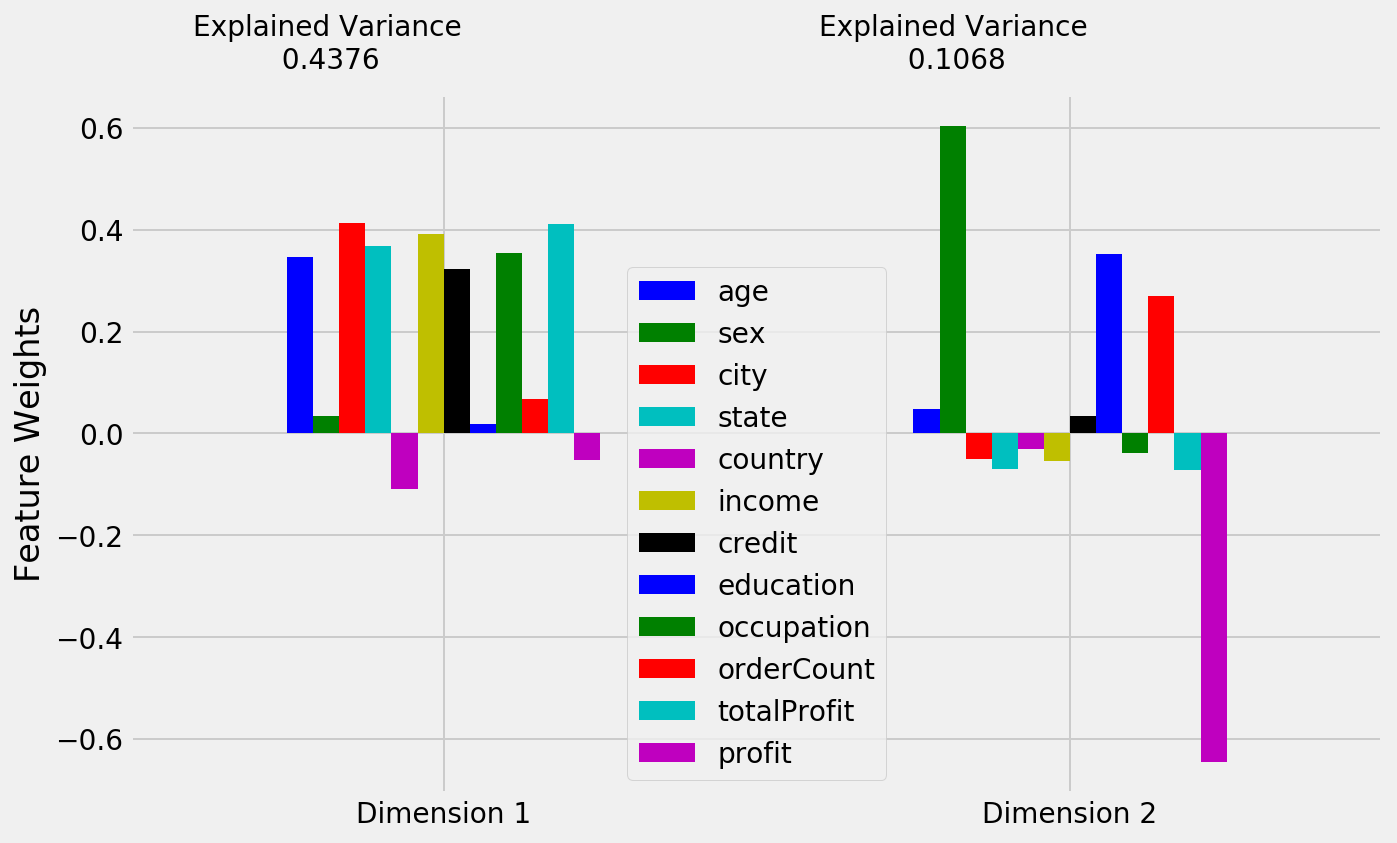

In [155]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["users"]=["age","sex", "city", "state","country","income","credit","education","occupation","orderCount","totalProfit","profit"]

scaler = StandardScaler()

X["users"] = scaler.fit_transform(df[index["users"]].values)
pca = PCA(n_components=2)
X["users"] = pca.fit_transform(X["users"])

pca_results = vs.pca_results(df[index["users"]], pca)

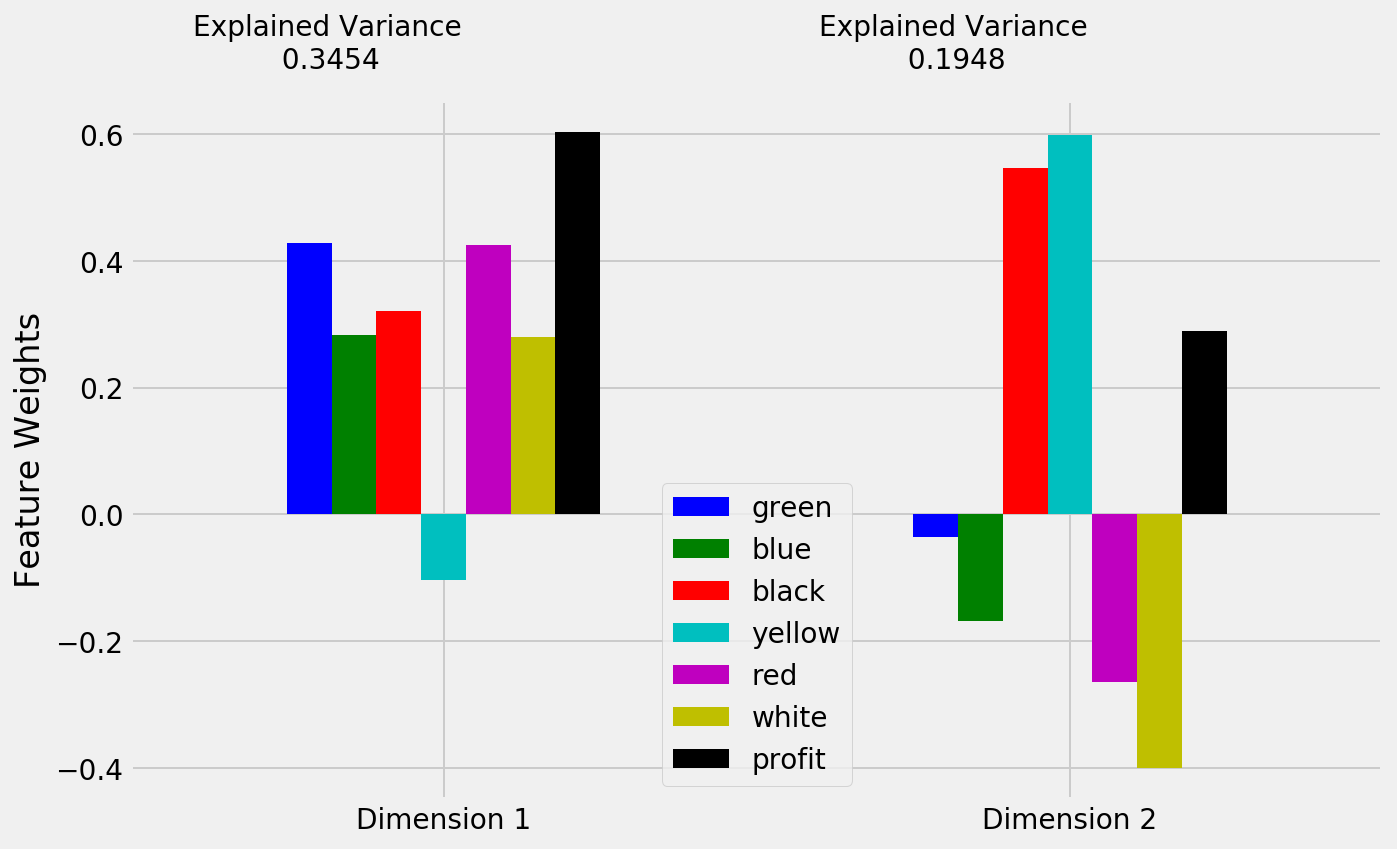

In [156]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["colors"]=["green","blue", "black", "yellow","red","white","profit"]

scaler = StandardScaler()

X["colors"] = scaler.fit_transform(df[index["colors"]].values)
pca = PCA(n_components=2)
X["colors"] = pca.fit_transform(X["colors"])

pca_results = vs.pca_results(df[index["colors"]], pca)

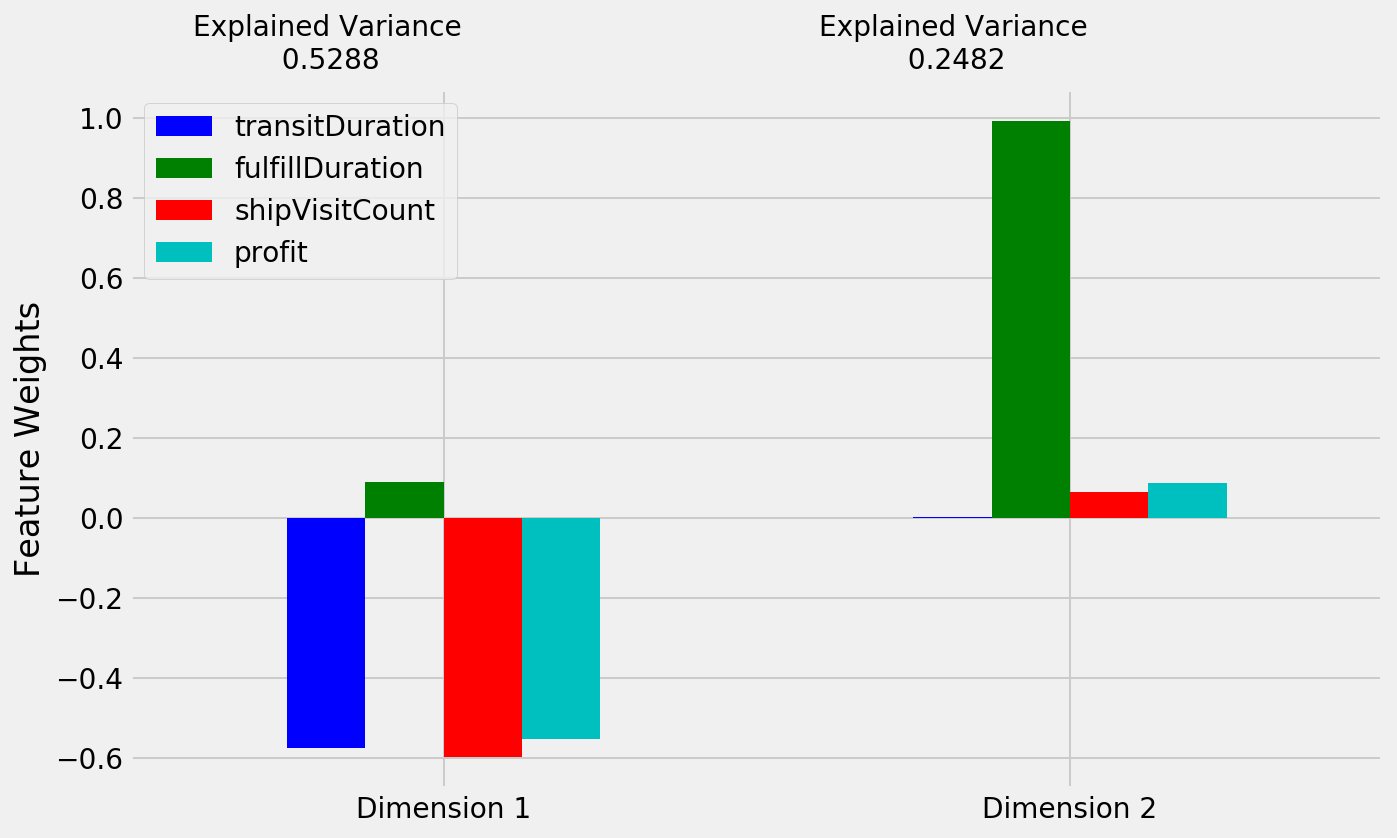

In [157]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["duration"]=["transitDuration","fulfillDuration","shipVisitCount", "profit"]

scaler = StandardScaler()

X["duration"] = scaler.fit_transform(df[index["duration"]].values)

pca = PCA(n_components=2)
X["duration"] = pca.fit_transform(X["duration"])

pca_results = vs.pca_results(df[index["duration"]], pca)

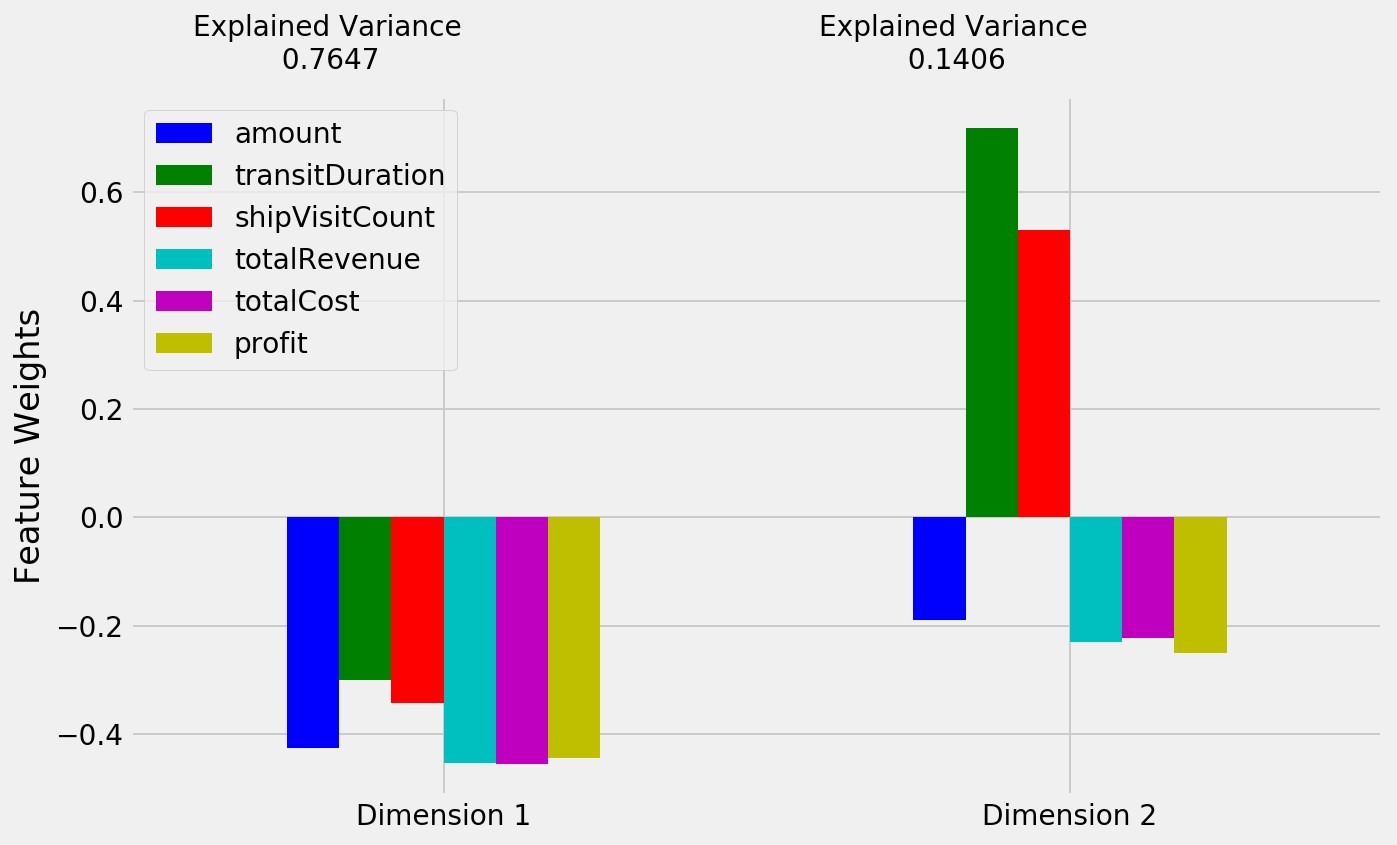

In [158]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["price"]=["amount","transitDuration", "shipVisitCount", "totalRevenue","totalCost","profit"]

scaler = StandardScaler()

X["price"] = scaler.fit_transform(df[index["price"]].values)
pca = PCA(n_components=2)
X["price"] = pca.fit_transform(X["price"])

pca_results = vs.pca_results(df[index["price"]], pca)

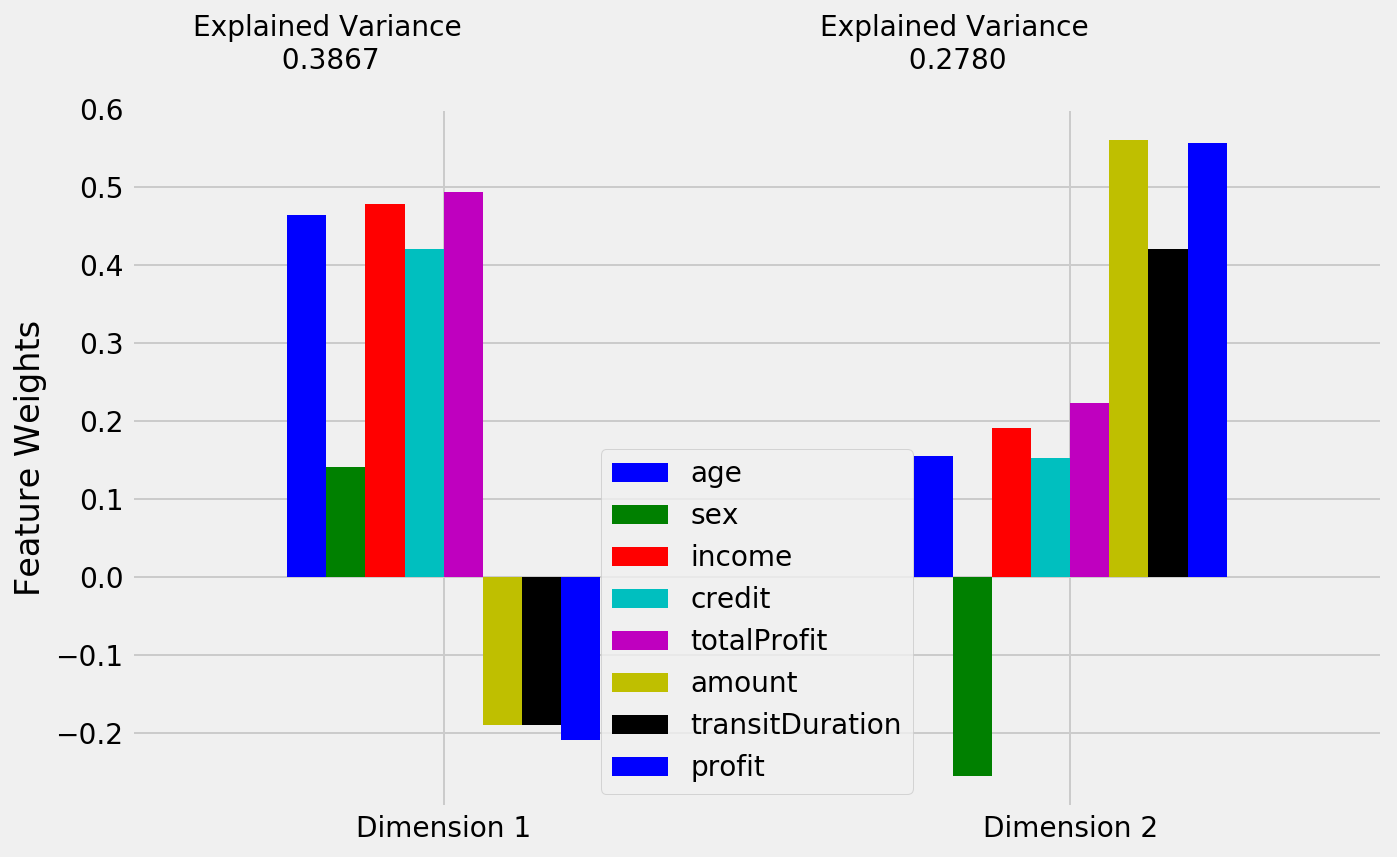

In [159]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
index["complex"]=["age","sex", "income", "credit",\
        "totalProfit","amount","transitDuration",\
        "profit" ]

scaler = StandardScaler()

X["complex"] = scaler.fit_transform(df[index["complex"]].values)

pca = PCA(n_components=2)
X["complex"] = pca.fit_transform(X["complex"])

pca_results = vs.pca_results(df[index["complex"]], pca)

### Feature Selection

SSH and C&H scores agree on usng dataset  users


<Figure size 720x1440 with 0 Axes>

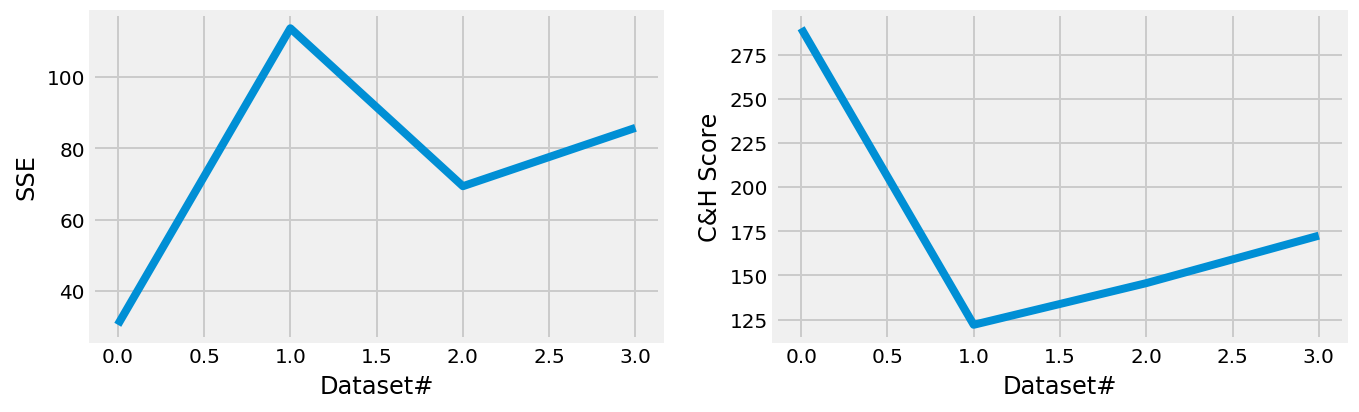

In [174]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
import matplotlib.pyplot as plt
import numpy as np

sse = {}
chs = {}
fig = plt.figure(1, figsize=(10,20))

X_keys = X.keys()

for i in xrange(4):
    #KMeans    
    km = KMeans(n_clusters=8,
               max_iter=1000)

    y_pred = km.fit_predict(X[X_keys[i]])
    
    #Measuremenet: SSE
    sse[i] = km.inertia_
    #Measuremenet: Calinski and Harabaz score
    chs[i]= calinski_harabaz_score(X[X_keys[i]], y_pred)

#Plotting SSE
fig = plt.figure(2,figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Dataset#")
plt.ylabel("SSE")

plt.subplot(1,2,2)
plt.plot(list(chs.keys()), list(chs.values()))
plt.xlabel("Dataset#")
plt.ylabel("C&H Score")

# Chooose the dataset index
i_sse = min(sse.items(), key = lambda x:x[1])[0]
i_chs = max(chs.items(), key = lambda x:x[1])[0]

# INDEX = X_keys[i_chs]
INDEX = "users"

if i_sse == i_chs:
    print "SSH and C&H scores agree on usng dataset ",INDEX
else:
    print "SSH and C&H scores conflict, choose C&H result: dataset ",INDEX

### PCA Analysis

## K-Means

### SSE change with K

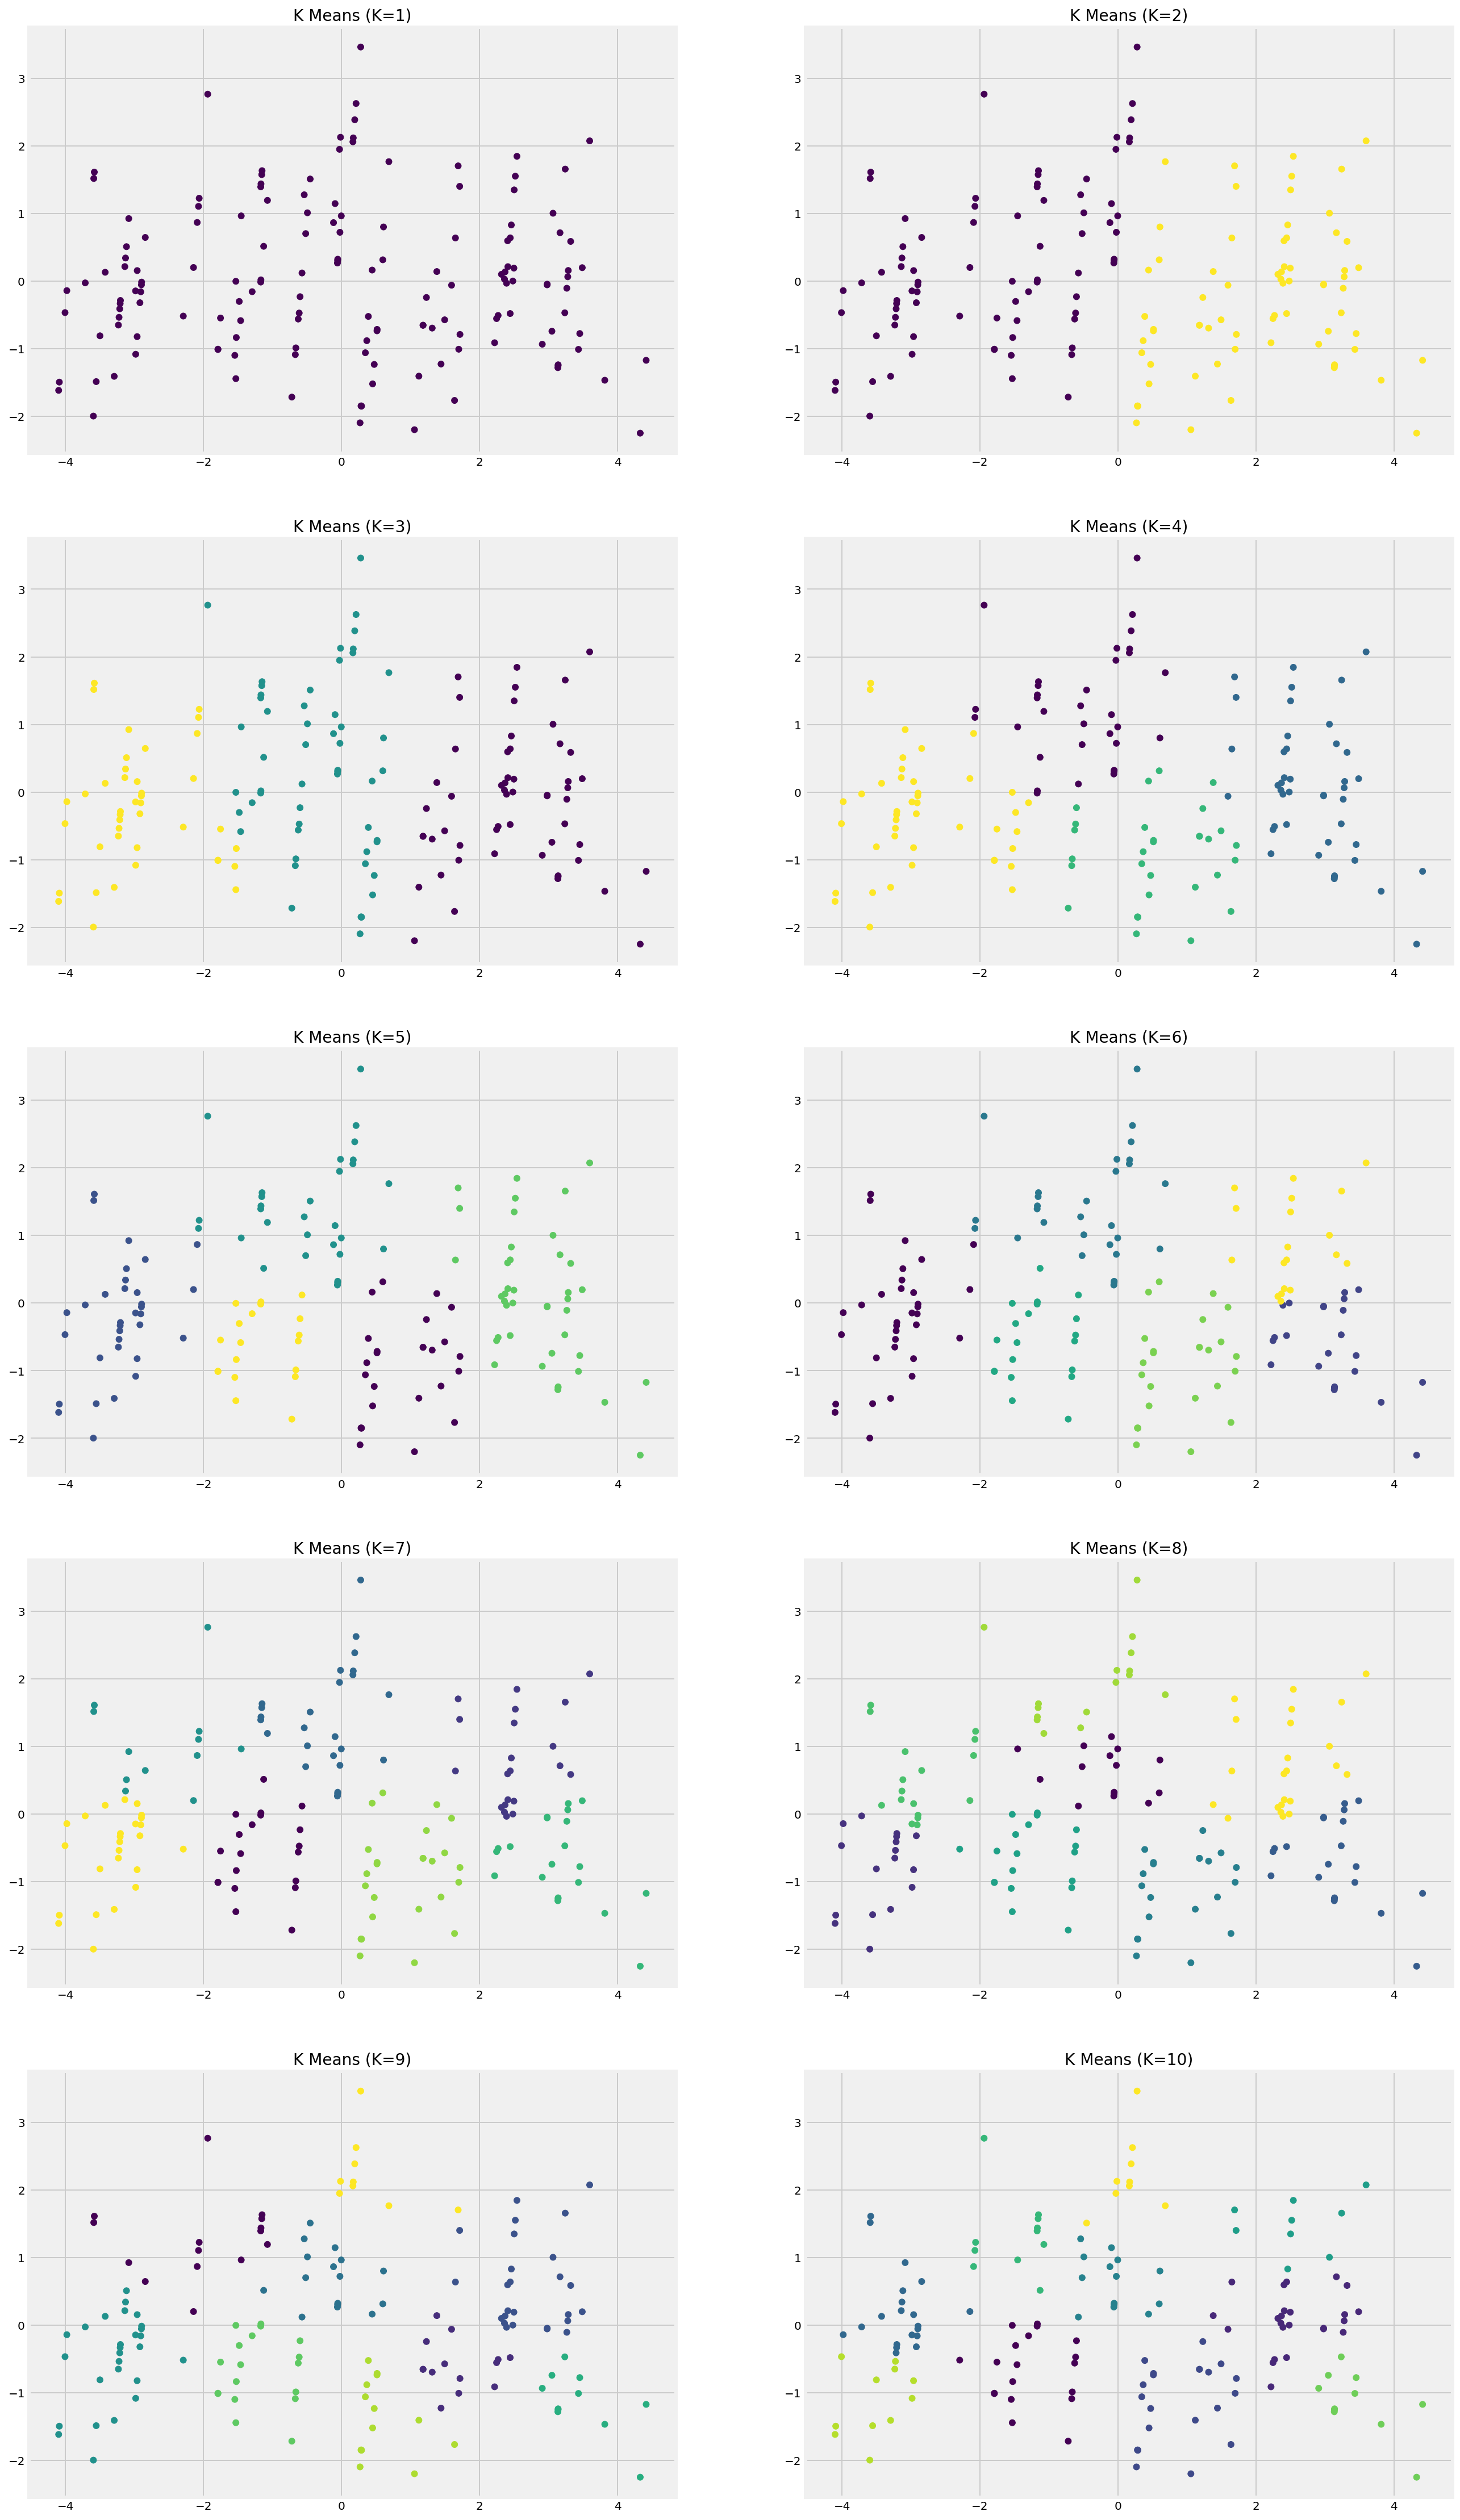

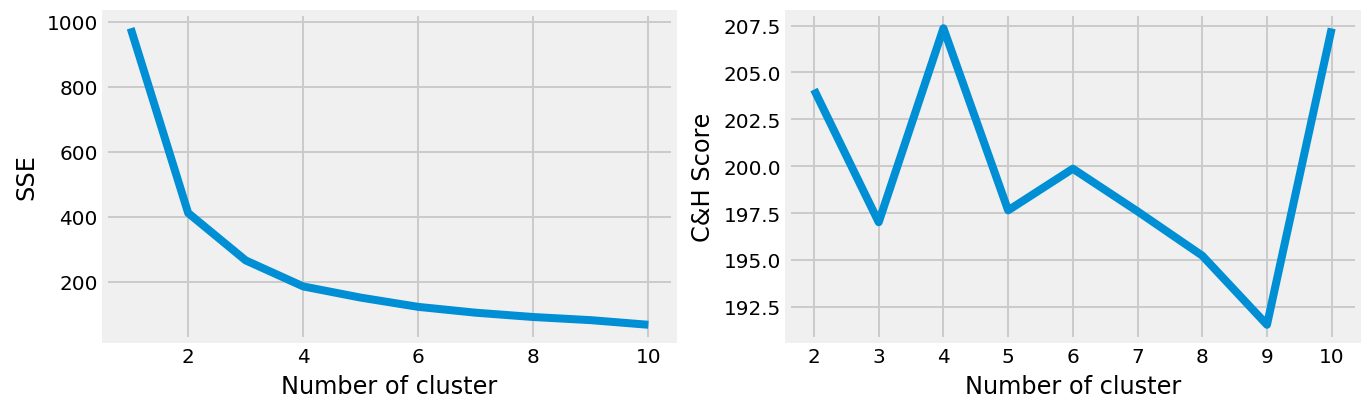

In [215]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
import matplotlib.pyplot as plt
import numpy as np

data = X[INDEX]

sse = {}
chs = {}
fig = plt.figure(1, figsize=(20,40))
for k in xrange(1,11):
    #KMeans    
    km = KMeans(n_clusters=k,
               max_iter=1000)

    y_pred = km.fit_predict(data)
    sse[k] = km.inertia_

    #Measuremenet: Calinski and Harabaz score
    if k!=1:
        chs[k]= calinski_harabaz_score(data, y_pred)
    
    plt.subplot(5,2,k)
    plt.scatter(data[:, 0], data[:, 1],  s=30, c=y_pred, cmap='viridis')
    plt.title("K Means (K=%d)"%k, fontsize=14)

#Plotting SSE
fig = plt.figure(2,figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

plt.subplot(1,2,2)
plt.plot(list(chs.keys()), list(chs.values()))
plt.xlabel("Number of cluster")
plt.ylabel("C&H Score")

# Chooose the best K
K = max(chs.items(), key = lambda x:x[1])[0]

### Cluster with best K

Calinski & Harabaz score: 207.20206119641978
SSE: 186.37445285403274


Text(0.5,1,'K Means (K=4)')

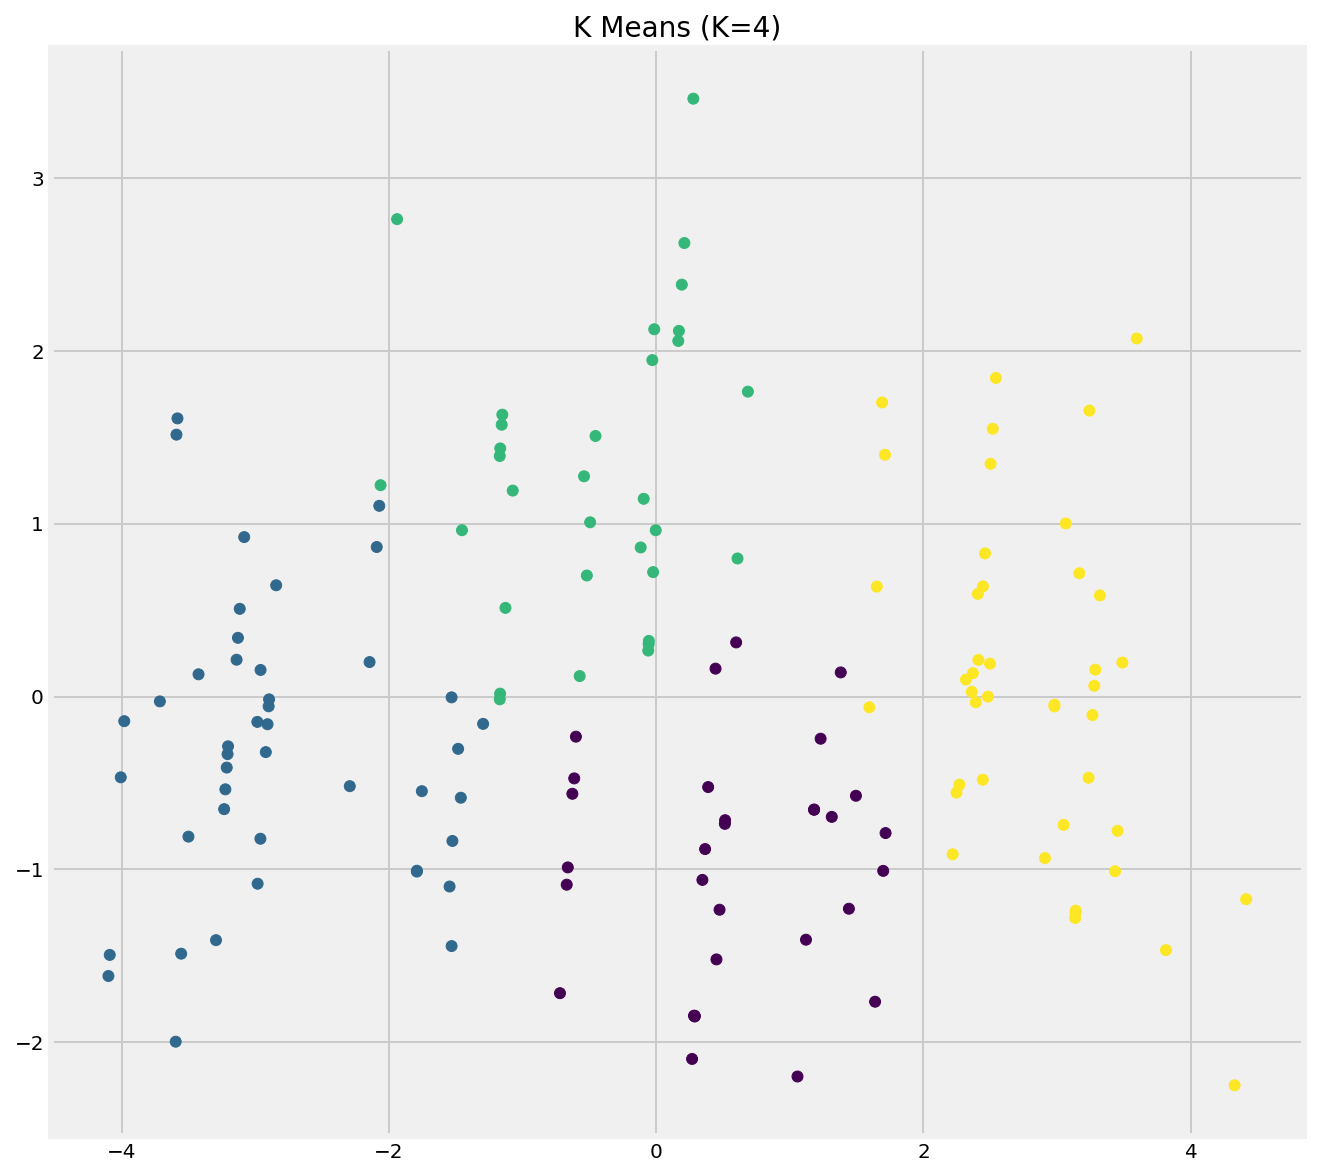

In [216]:
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabaz_score
import matplotlib.pyplot as plt
import numpy as np

#KMeans    
km = KMeans(n_clusters= K,
           max_iter=2000)

y_pred = km.fit_predict(data)

#Measuremenet: Calinski and Harabaz score
print "Calinski & Harabaz score:",calinski_harabaz_score(data, y_pred)  
print "SSE:",km.inertia_ 

#Plotting
fig = plt.figure(1, figsize=(10,10))
plt.scatter(data[:, 0], data[:, 1], c=y_pred, s=30, cmap='viridis')
plt.title("K Means (K=%d)"%K, fontsize=14)

### Examine clustered data

#### Customer with pofit

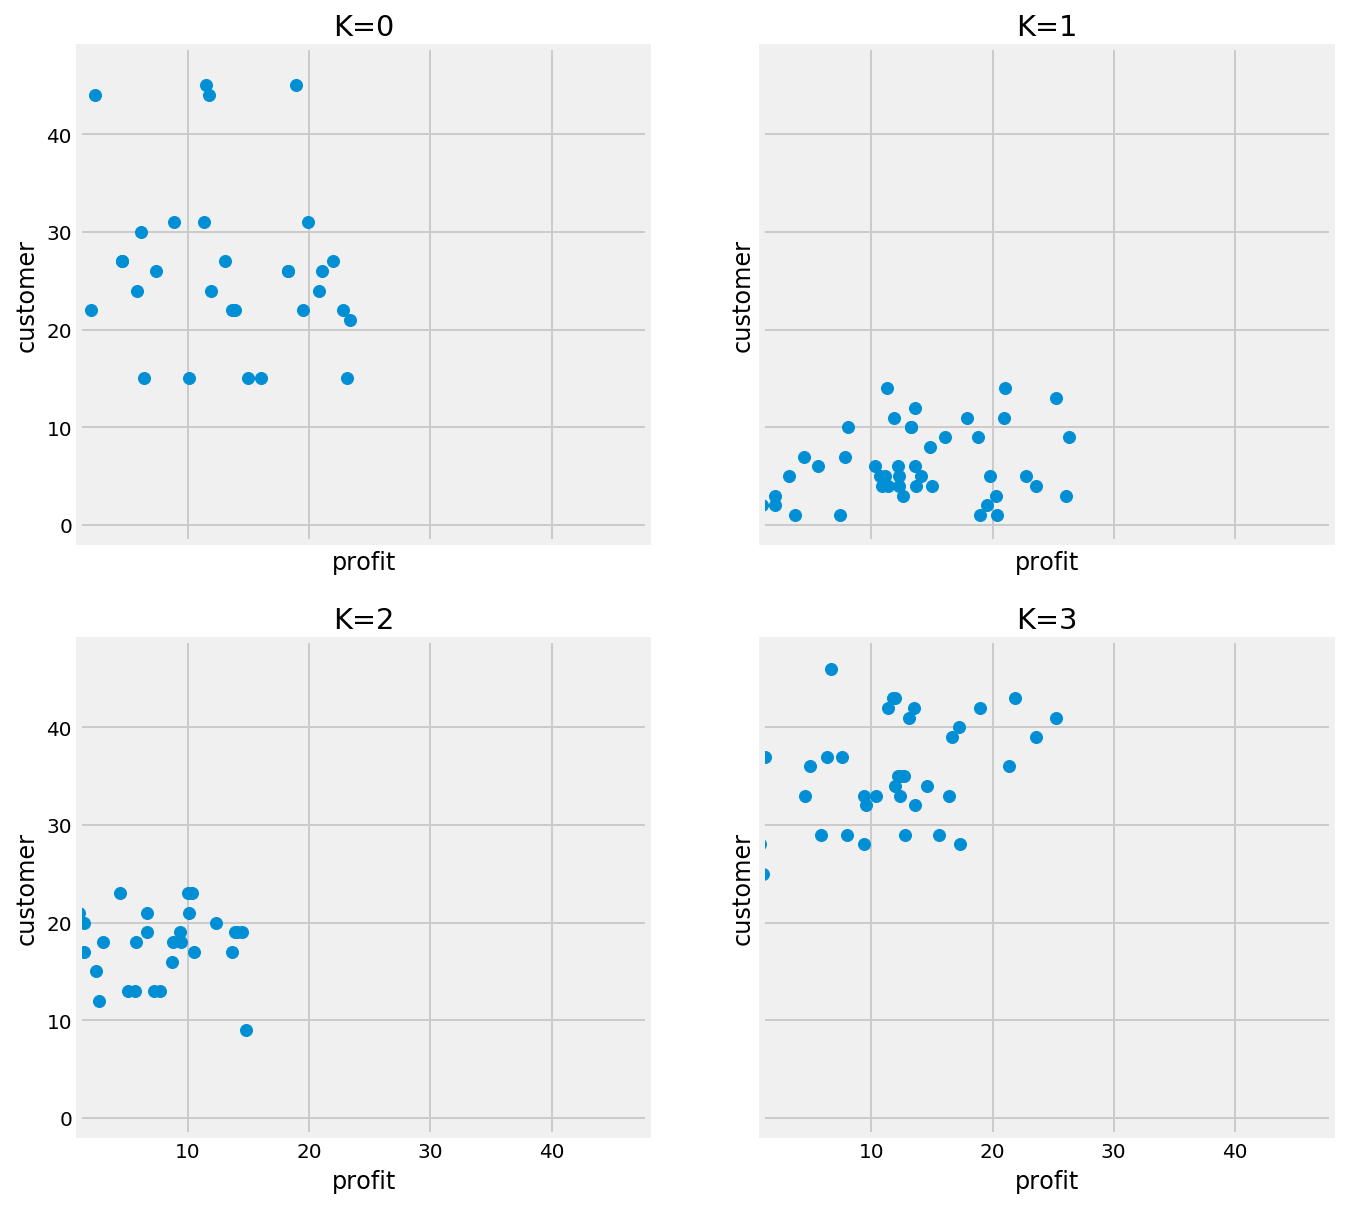

In [222]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["customer"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('customer')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

#### Credit, income with profit

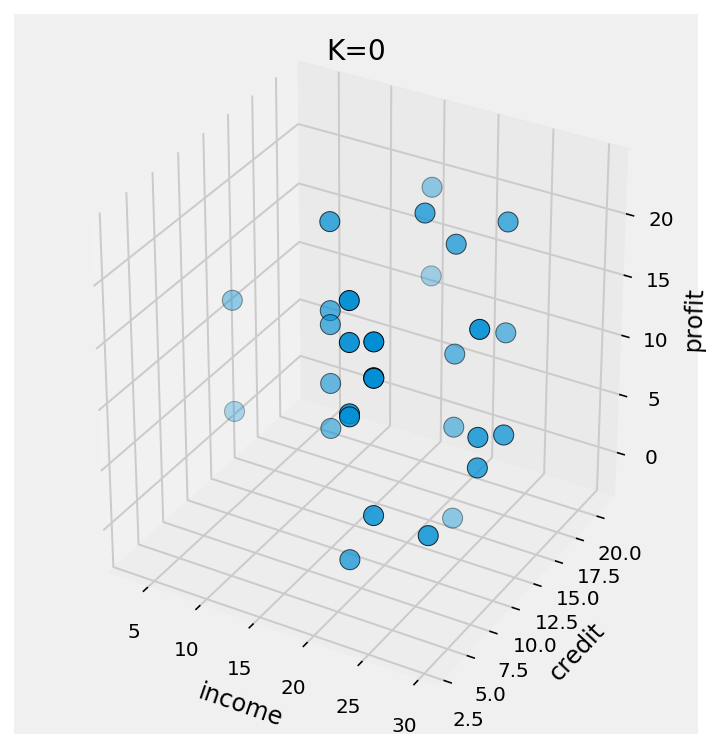

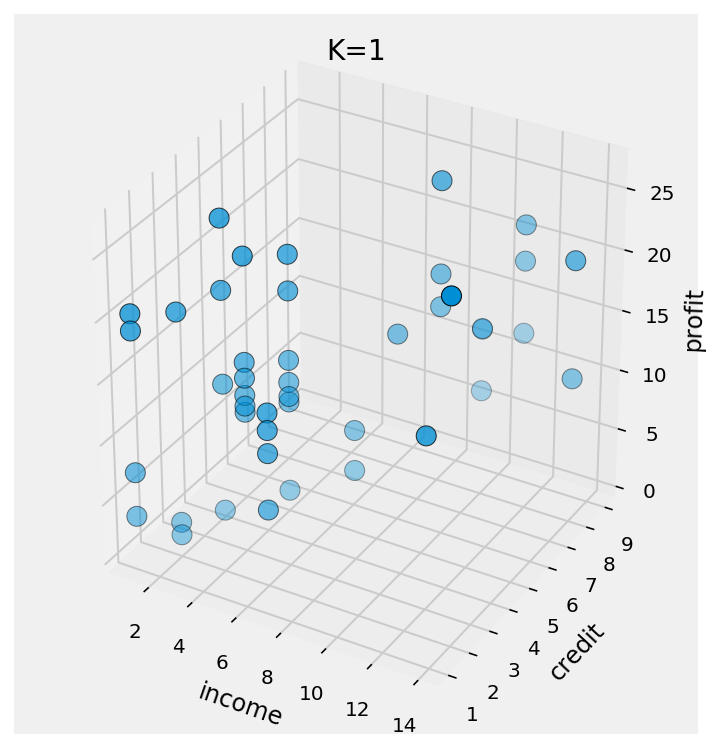

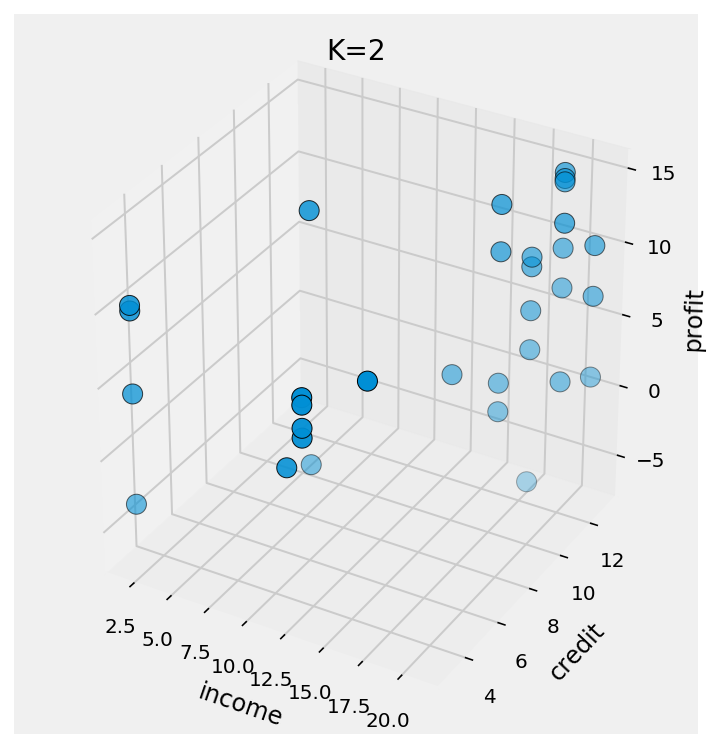

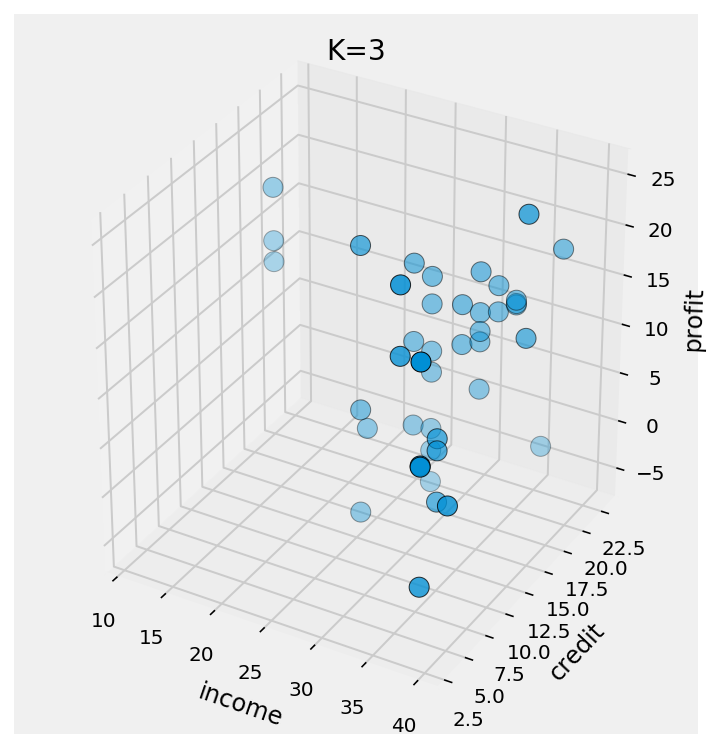

In [218]:
from mpl_toolkits.mplot3d import Axes3D

for k in xrange(K):
    fig = plt.figure(1, figsize=(5,5))
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1])
    ax.scatter(cluster[k]["income"], cluster[k]["credit"], cluster[k]["profit"],edgecolor="k", s=100)
    ax.set_xlabel("income")
    ax.set_ylabel("credit")
    ax.set_zlabel("profit")
    plt.title("K=%d"%k, fontsize=14)
    plt.tight_layout()
    plt.show()


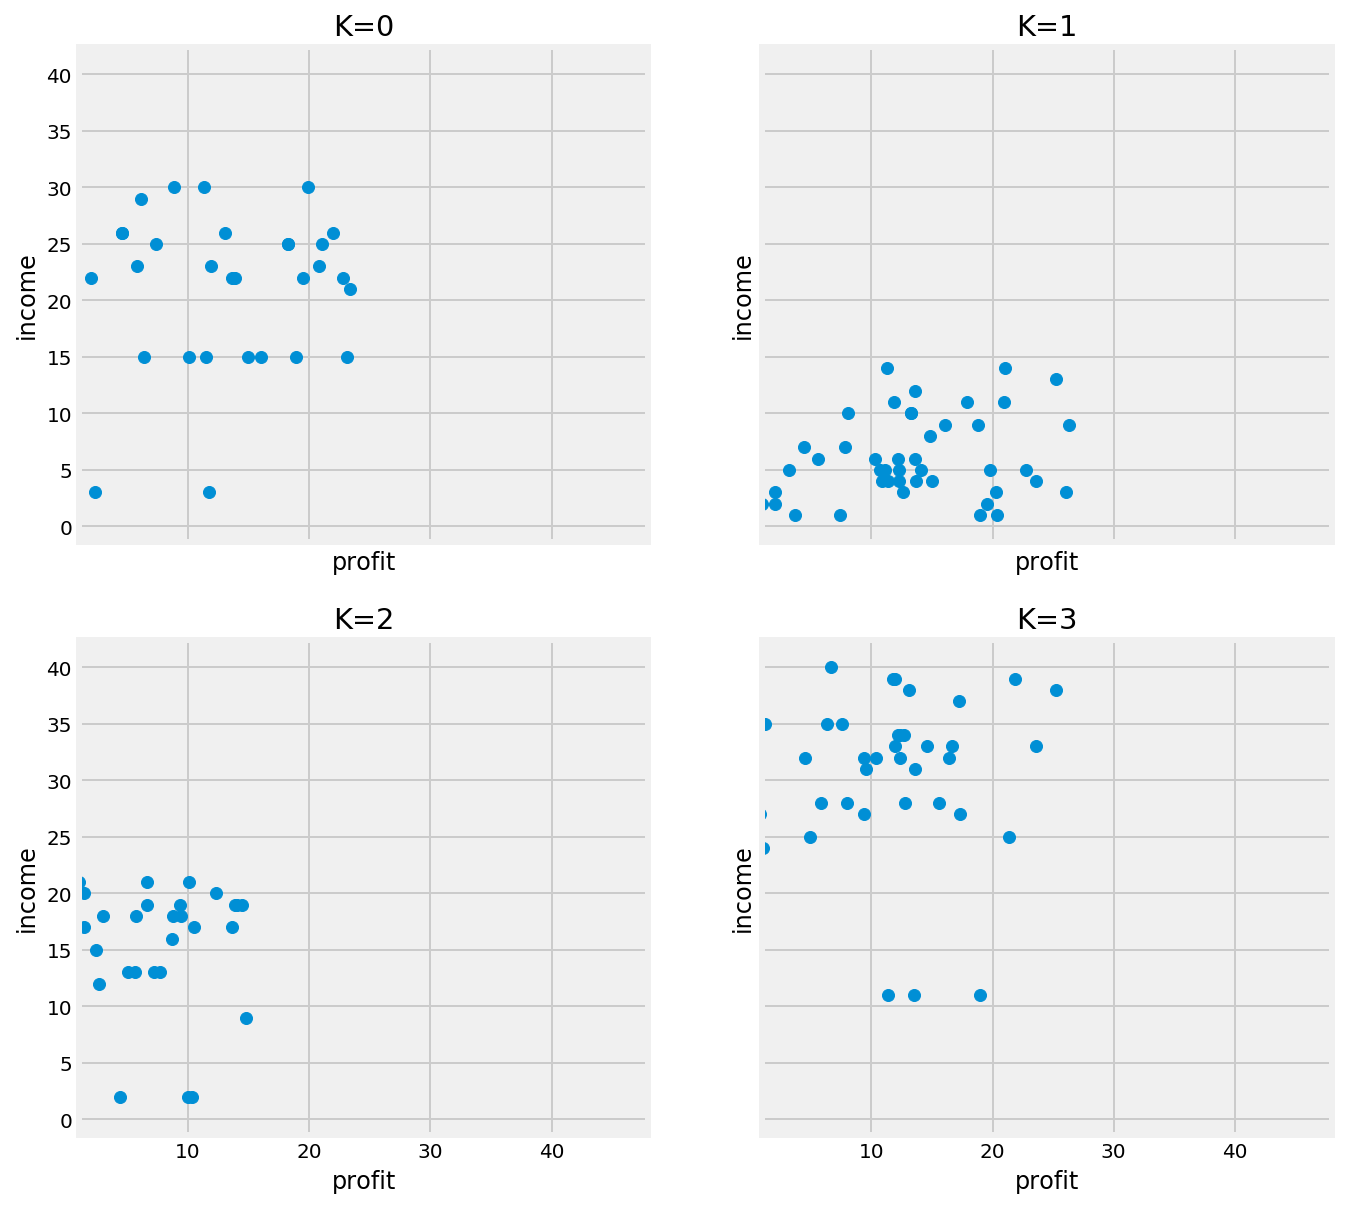

In [221]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["income"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('income')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

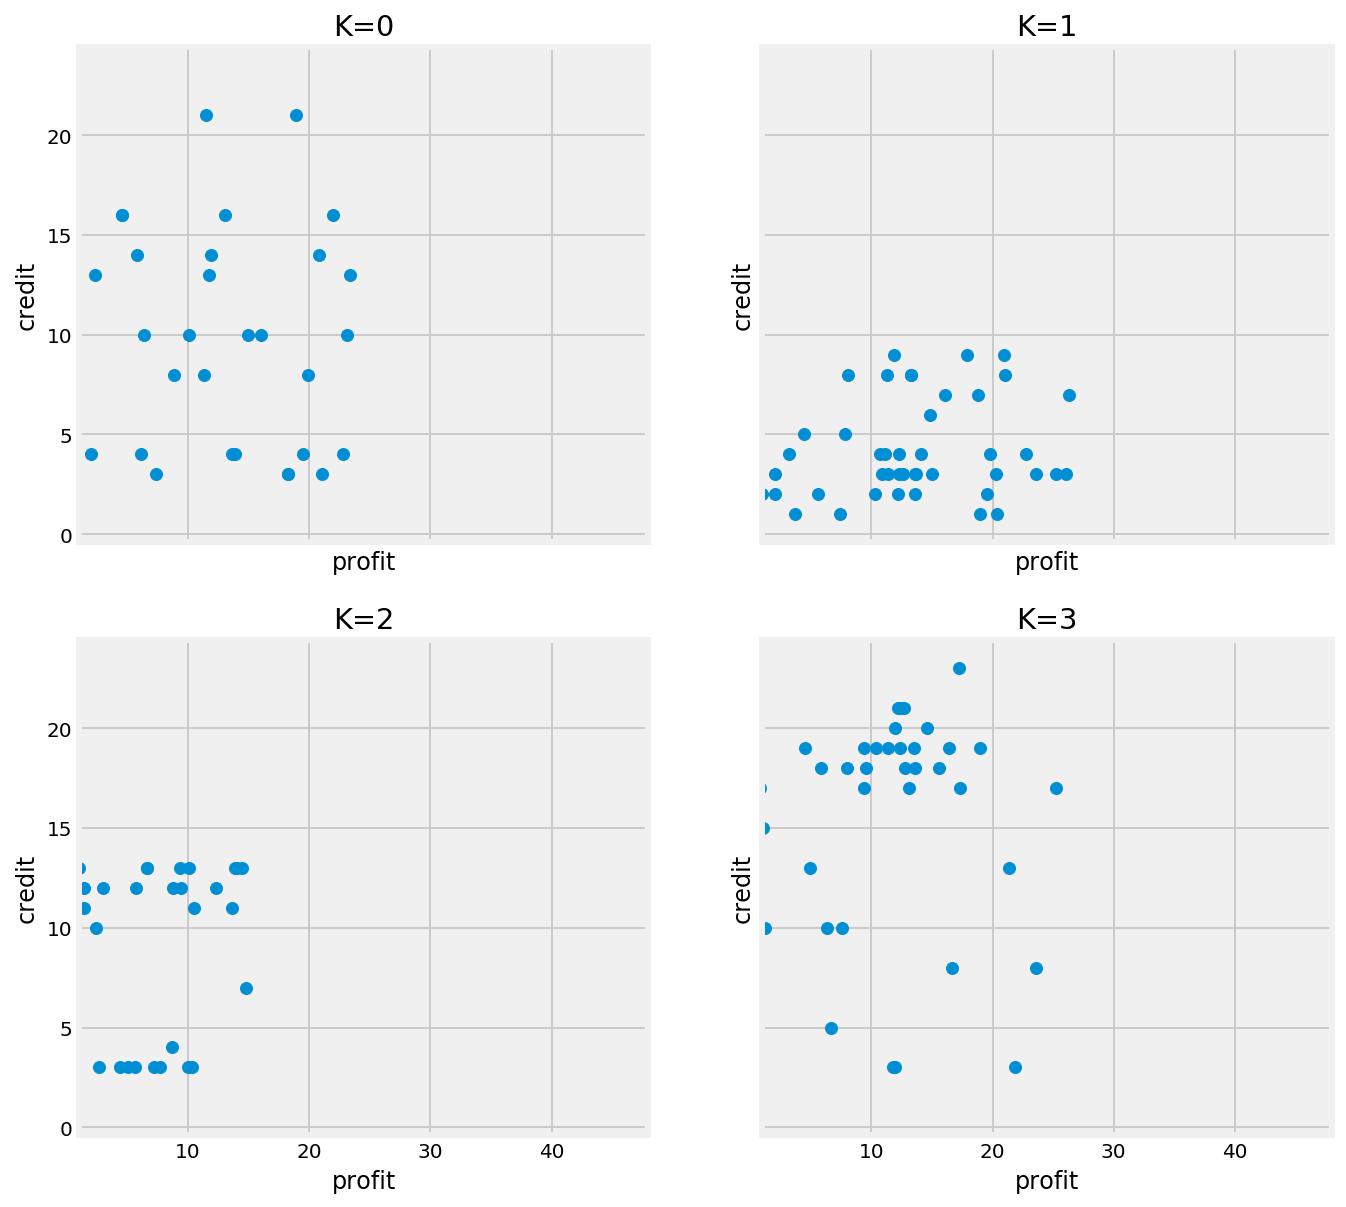

In [223]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["credit"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('credit')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

#### Age, sex with profit

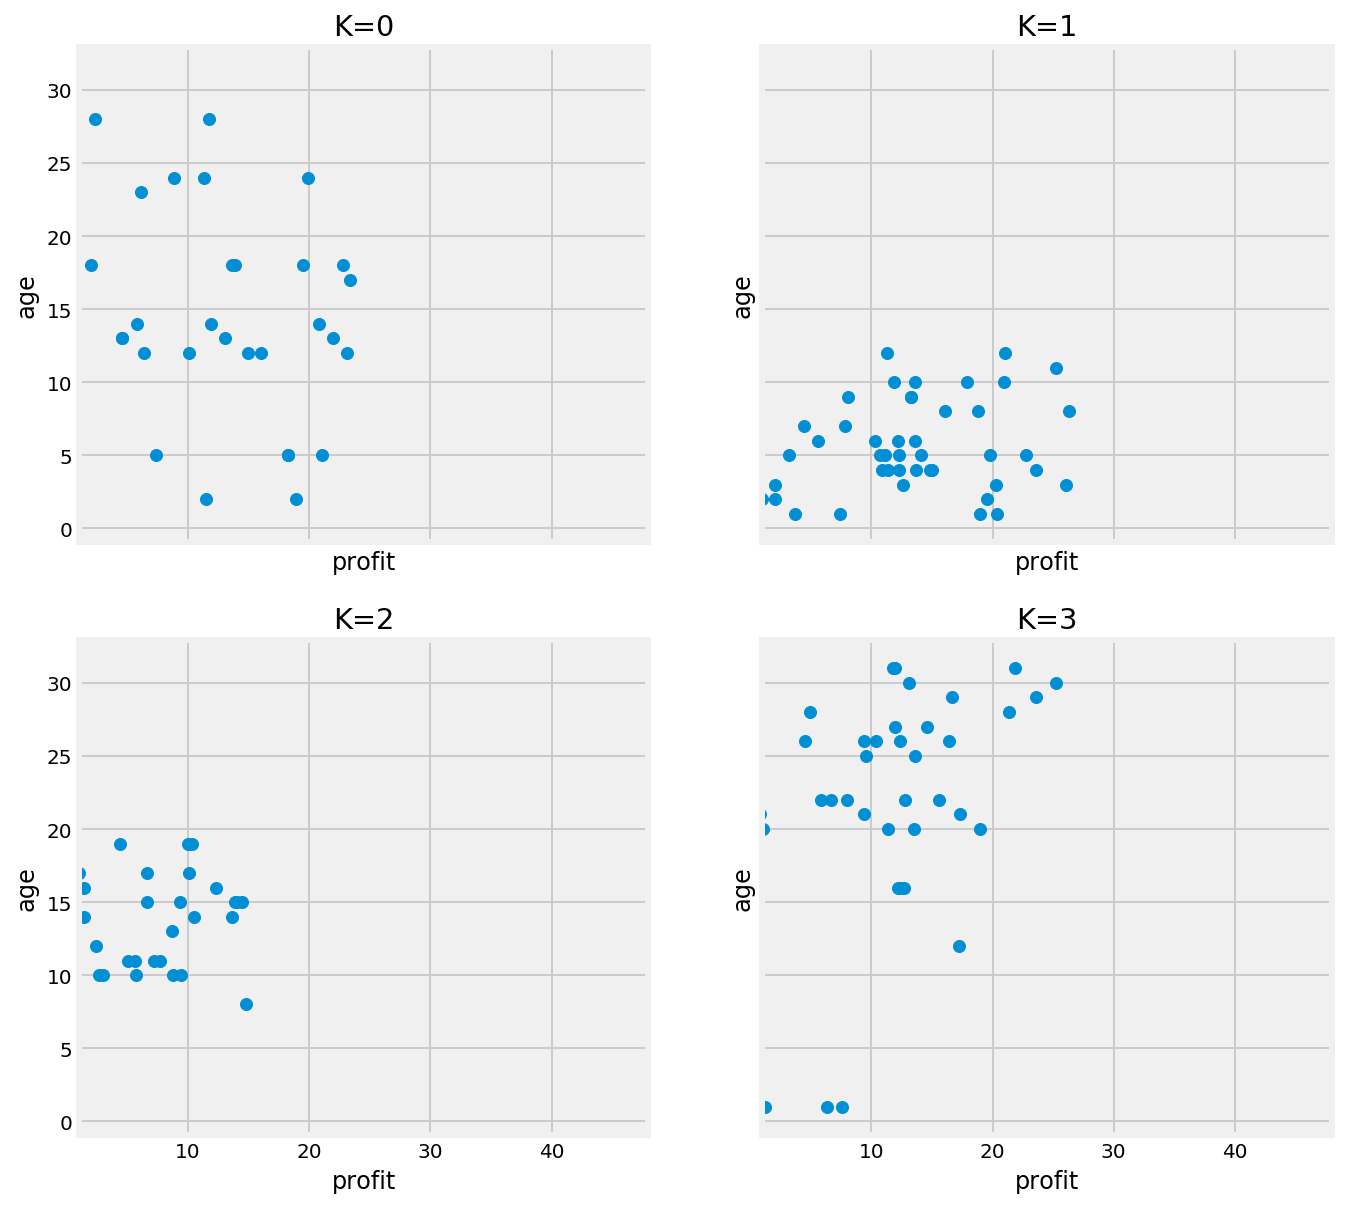

In [226]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["age"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('age')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

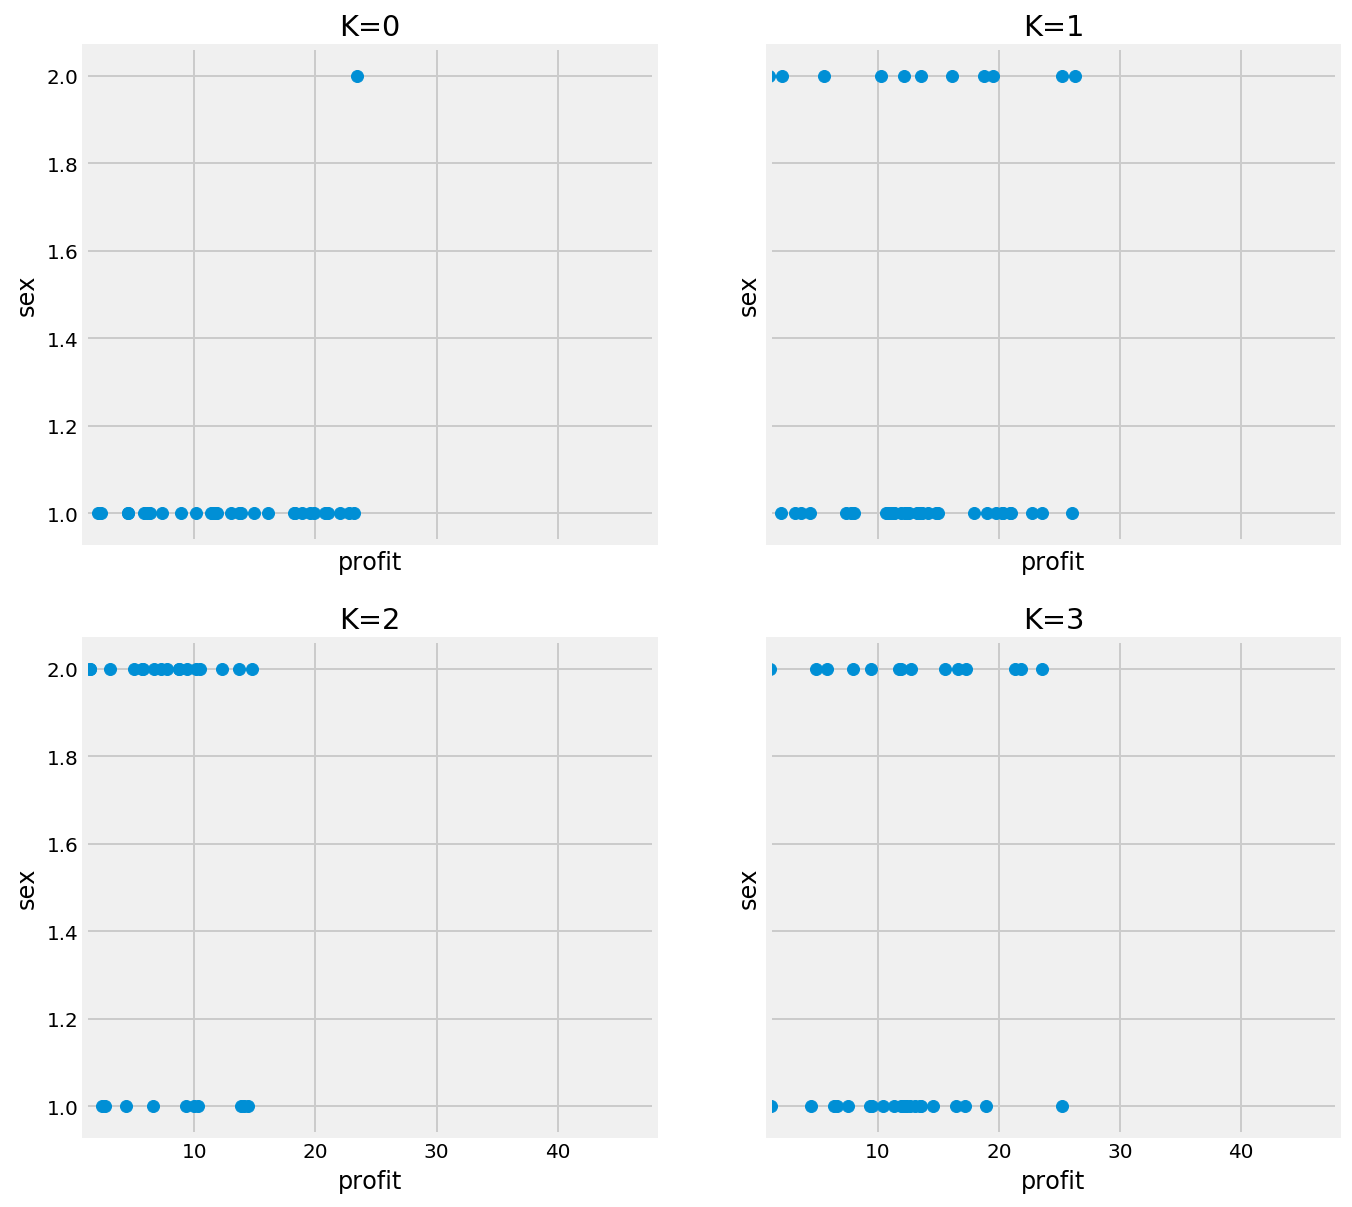

In [232]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["sex"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('sex')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

#### Education, occupation and profit

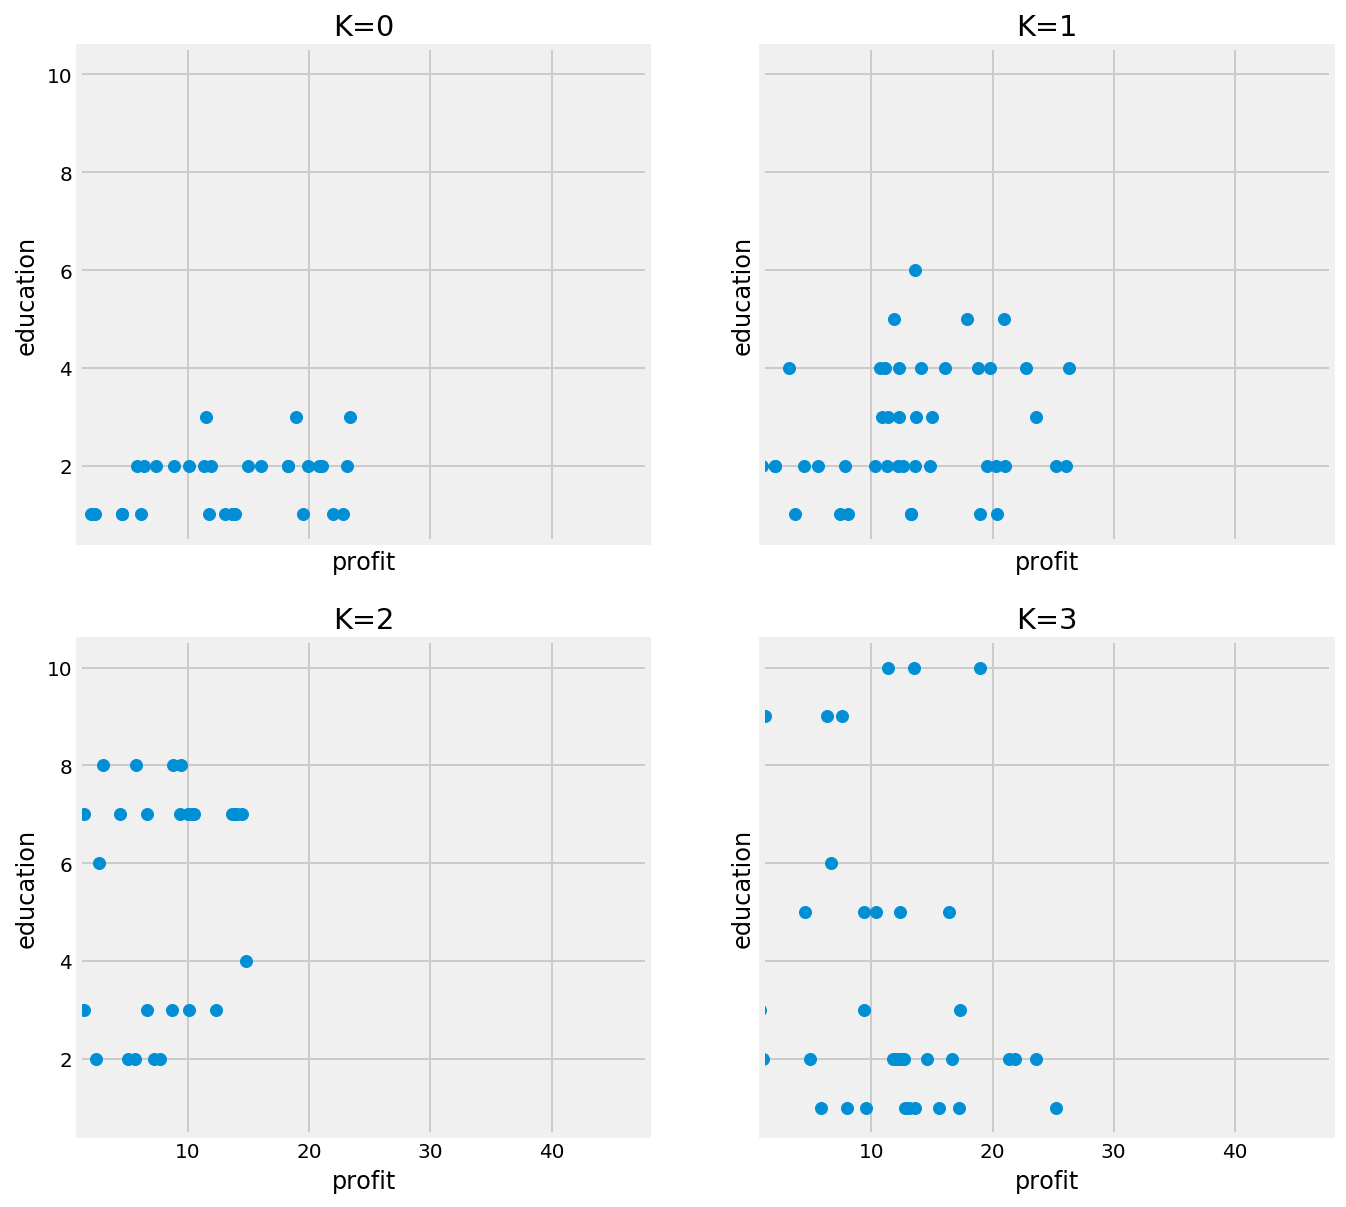

In [235]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["education"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('education')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

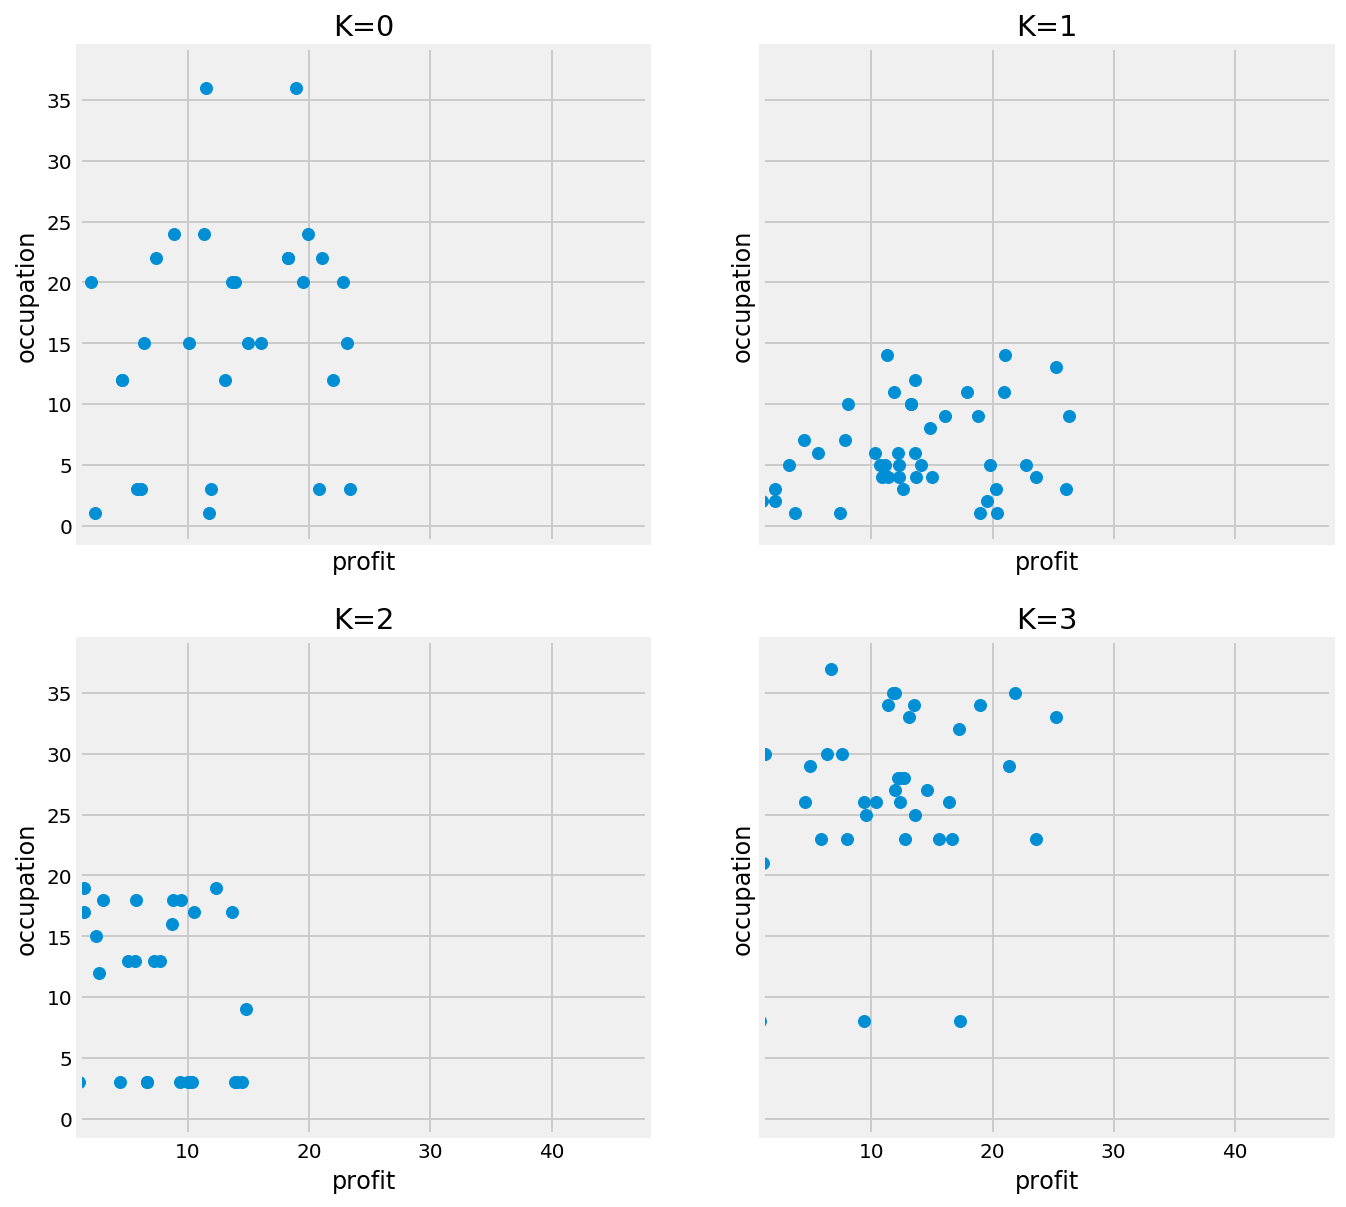

In [239]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["occupation"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('occupation')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

#### Location and profit

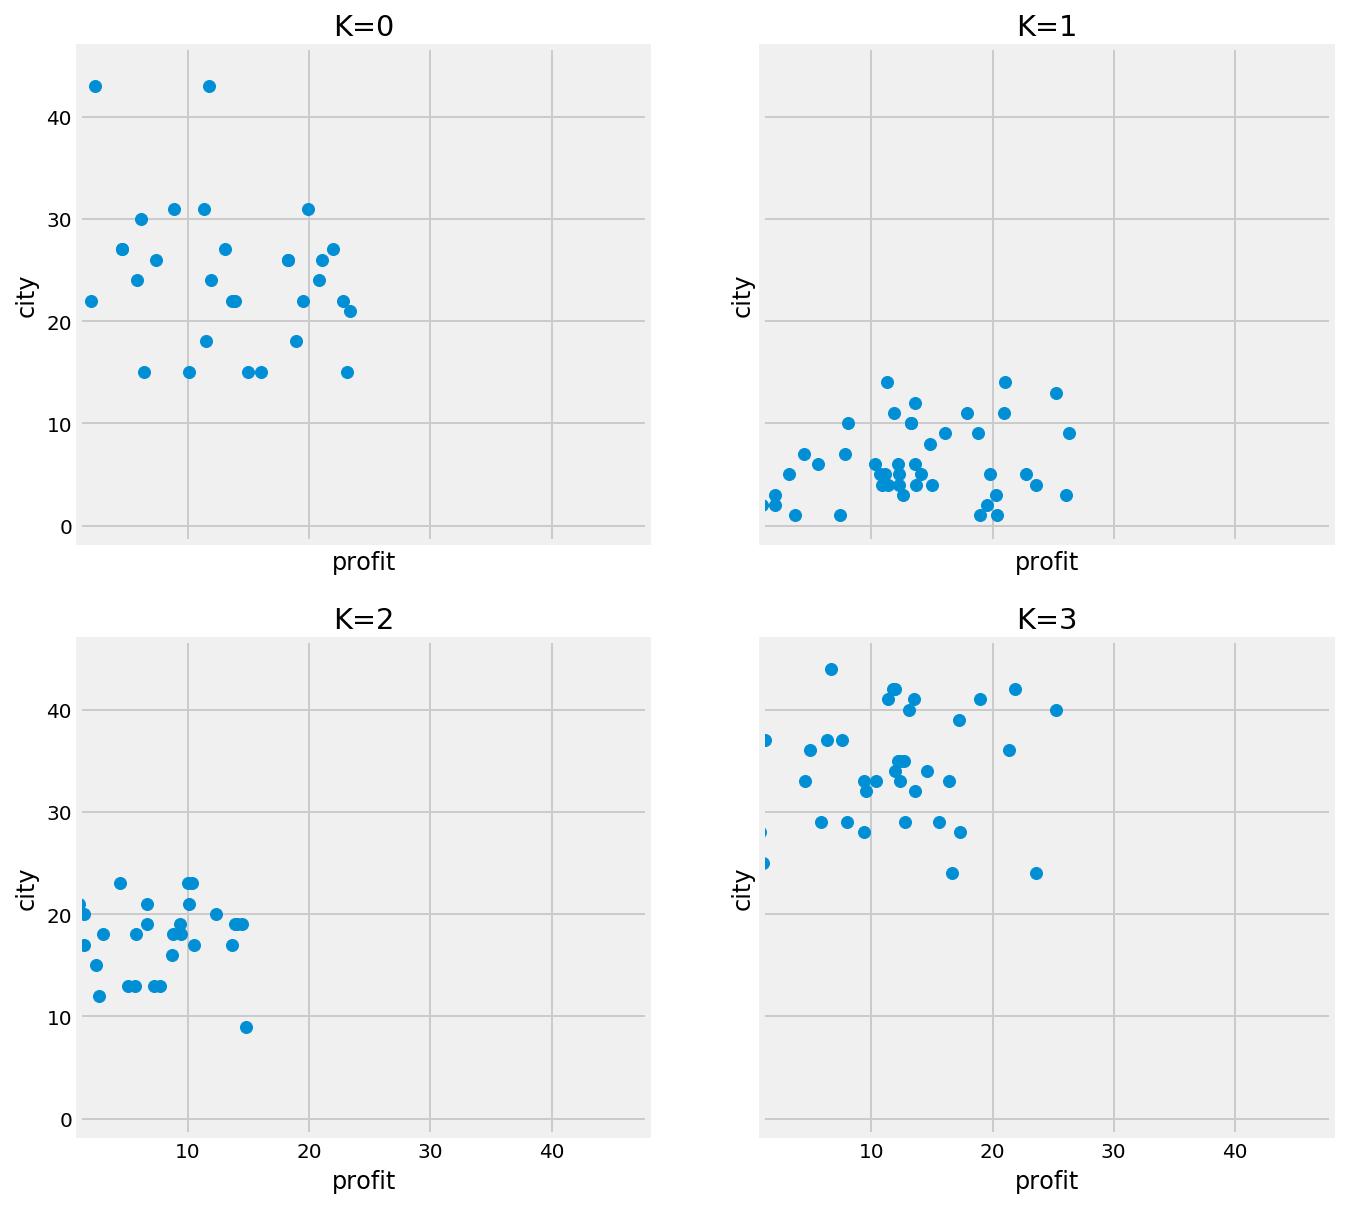

In [240]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["city"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('city')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;

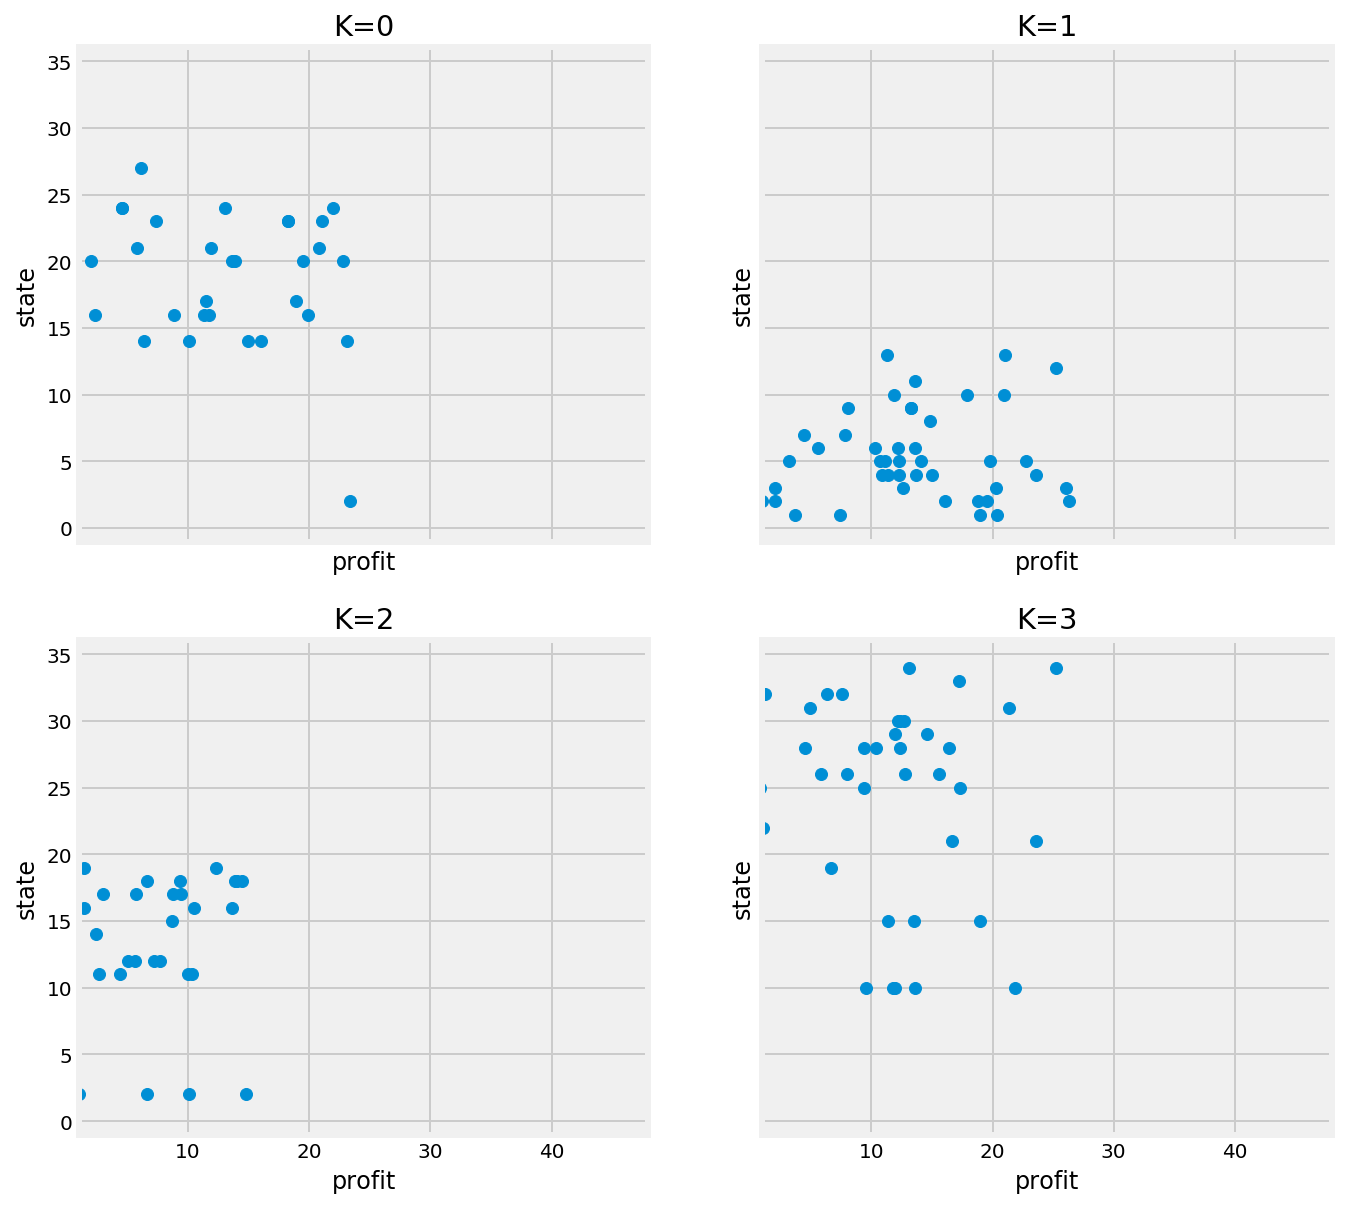

In [241]:
cluster = {}
fig, axes = plt.subplots(K/2,2,sharex=True, sharey=True,figsize=(10,10))


for k in xrange(K):
    cluster[k] = df.loc[[i for i in range(len(km.labels_)) if km.labels_[i]==k]]
    ax = axes[k/2, k%2]
    ax.scatter(cluster[k]["profit"],cluster[k]["state"])
    ax.set_xlim([1, id+1])
    ax.set_xlabel('profit')
    ax.set_ylabel('state')
    ax.set_title('K=%d'%k)
    if(k==K-1):
        break;